<a href="https://colab.research.google.com/github/Yunseokjin/Final-Team1/blob/main/(%EC%A0%84%EC%B2%98%EB%A6%AC%ED%8C%8C%EC%9D%BC)%EA%B0%80%EC%84%A4_3_%22%EC%96%B8%EC%96%B4%EC%9D%98_%EC%9E%A5%EB%B2%BD%2C_%EB%A6%AC%EB%B7%B0%EC%9D%98_%EC%9E%A5%EB%B2%BD_%EB%A6%AC%EB%B7%B0_%EC%96%B8%EC%96%B4%EA%B6%8C%EB%B3%84_%ED%8C%A8%ED%84%B4_%EB%B6%84%EC%84%9D%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.라이브러리

In [ ]:
#한글 글씨 폰트 설치
%%capture
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fm.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumGothic.ttf')
plt.rcParams['font.family'] = 'NanumGothic'

# 표에서 ('-') 마이너스 표시
plt.rcParams['axes.unicode_minus'] = False

In [ ]:
# 필수 라이브러리 설치
!pip install konlpy -q
!pip install nltk -q
!pip install stopwordsiso -q

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from konlpy.tag import Okt
import nltk
import re # re 모듈 임포트 추가
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
print("NLTK 필수 데이터를 다운로드합니다...")
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('punkt_tab', quiet=True) # <<< 문제 해결을 위한 핵심 코드
print("NLTK 데이터 준비 완료.")


NLTK 필수 데이터를 다운로드합니다...
NLTK 데이터 준비 완료.


# 1.데이터준비

In [ ]:
# ==============================================================================
# 1단계: 데이터 준비 및 주요 언어 그룹 선정
# ==============================================================================
print("\n--- 1단계: 데이터 준비 및 주요 언어 그룹 선정 시작 ---")

# ★★★ 여기에 전처리된 최종 데이터 파일 경로를 입력해주세요 ★★★
df = pd.read_csv('/content/weighted_score_above_08_250924.csv')

# 'genre' 컬럼이 없는 경우에 대한 예외 처리
if 'genre' not in df.columns:
    print("경고: 'genre' 컬럼이 없어 임시로 'Unknown' 장르를 생성합니다.")
    df['genre'] = 'Unknown'

# 리뷰 수가 많은 상위 10개 언어 그룹 확인
top_n_languages = 10
language_counts = df['language'].value_counts()
top_languages = language_counts.head(top_n_languages).index.tolist()

print(f"리뷰 수 기준 상위 {top_n_languages}개 언어:")
print(language_counts.head(top_n_languages))

# 상위 언어 그룹 데이터만 필터링
df_top_lang = df[df['language'].isin(top_languages)].copy()
print(f"\n분석 대상 리뷰 수: {len(df_top_lang)}")



--- 1단계: 데이터 준비 및 주요 언어 그룹 선정 시작 ---
경고: 'genre' 컬럼이 없어 임시로 'Unknown' 장르를 생성합니다.
리뷰 수 기준 상위 10개 언어:
language
schinese     80741
english      54172
russian      20785
turkish       7448
spanish       6520
brazilian     5738
koreana       2730
polish        1754
tchinese      1727
japanese      1436
Name: count, dtype: int64

분석 대상 리뷰 수: 183051


# 2.장르별by언어별 히트맵

In [ ]:
# ==============================================================================
# 2단계 (수정): 여러 장르 컬럼을 반영한 '장르 선호도' 분석
# ==============================================================================
print("\n--- 2단계 (수정): 여러 장르 컬럼을 반영한 장르 선호도 분석 시작 ---")

# 1. 분석에 사용할 컬럼만 선택하고, 데이터 구조를 재편 (Melt)
#    language를 기준으로 genres1, genres2, genres3를 세로로 긴 형태로 변환합니다.
df_genre_analysis = df_top_lang[['language', 'genres1', 'genres2', 'genres3']]
df_melted = df_genre_analysis.melt(
    id_vars=['language'],
    value_vars=['genres1', 'genres2', 'genres3'],
    value_name='genre'
)

# 2. 장르 값이 없는 행(NaN)은 분석에서 제외
df_melted.dropna(subset=['genre'], inplace=True)

# 3. 언어와 재편된 장르 간의 교차표(crosstab) 생성
#    이제 각 리뷰는 해당하는 모든 장르에 대해 카운트됩니다.
lang_genre_crosstab = pd.crosstab(df_melted['language'], df_melted['genre'])

# 4. 리뷰가 많은 상위 15개 장르만 선택하여 시각화 (너무 많으면 히트맵이 복잡해짐)
top_15_genres = lang_genre_crosstab.sum().nlargest(15).index
lang_genre_crosstab_top15 = lang_genre_crosstab[top_15_genres]

# 5. 각 언어 내에서 장르가 차지하는 '비율'로 변환 (정규화)
lang_genre_norm = lang_genre_crosstab_top15.div(lang_genre_crosstab_top15.sum(axis=1), axis=0)



--- 2단계 (수정): 여러 장르 컬럼을 반영한 장르 선호도 분석 시작 ---


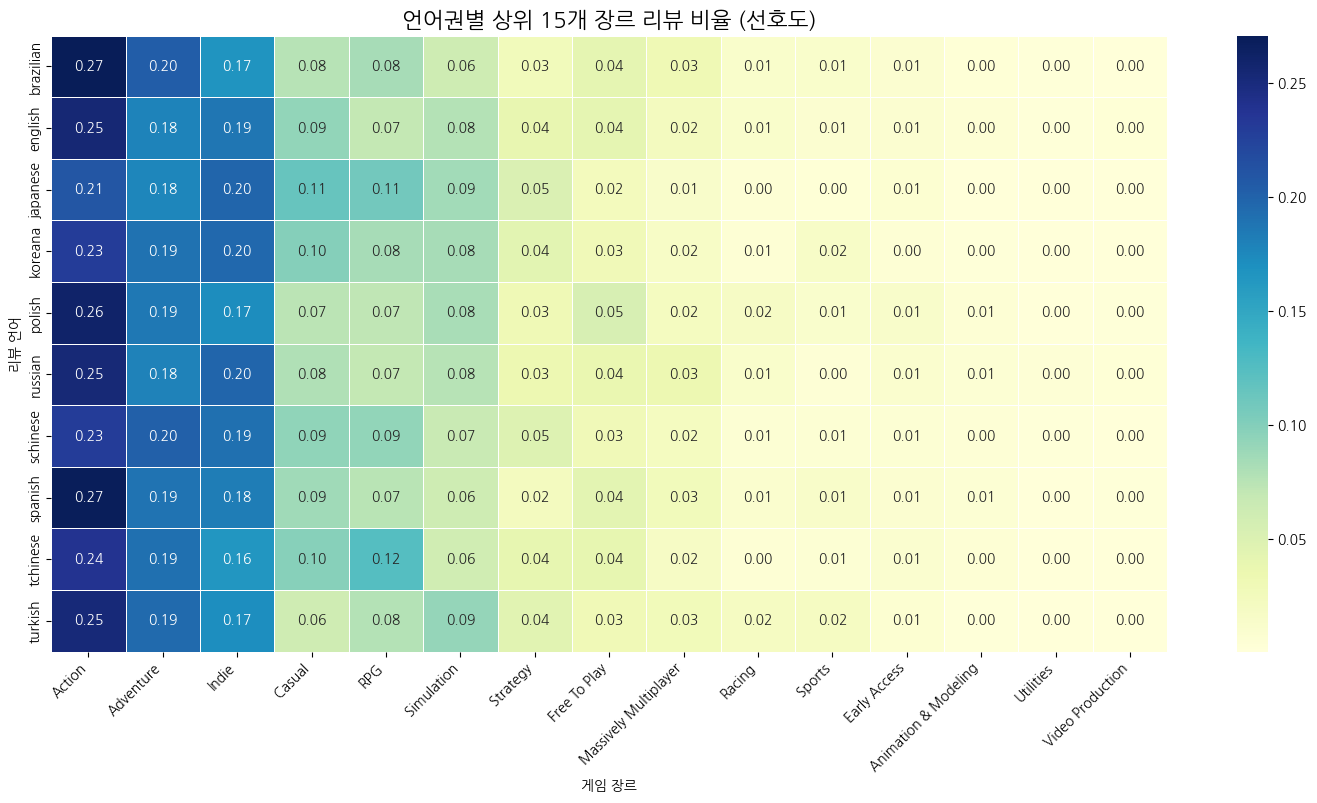

In [ ]:
# 6. 히트맵(Heatmap)으로 시각화
plt.figure(figsize=(18, 8))
sns.heatmap(lang_genre_norm, cmap="YlGnBu", annot=True, fmt=".2f", linewidths=.5)
plt.title('언어권별 상위 15개 장르 리뷰 비율 (선호도)', fontsize=16)
plt.xlabel('게임 장르')
plt.ylabel('리뷰 언어')
plt.xticks(rotation=45, ha='right')
plt.show()


# 3.언어별 리뷰영향력(도움돼요,재밌어요)


--- 3단계: 언어권별 리뷰 영향력 패턴 비교 분석 시작 ---


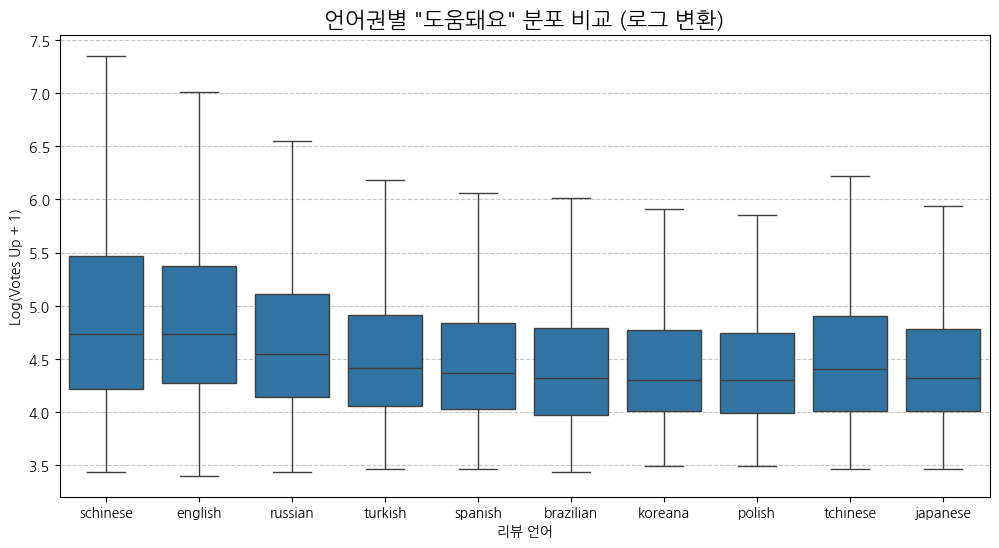

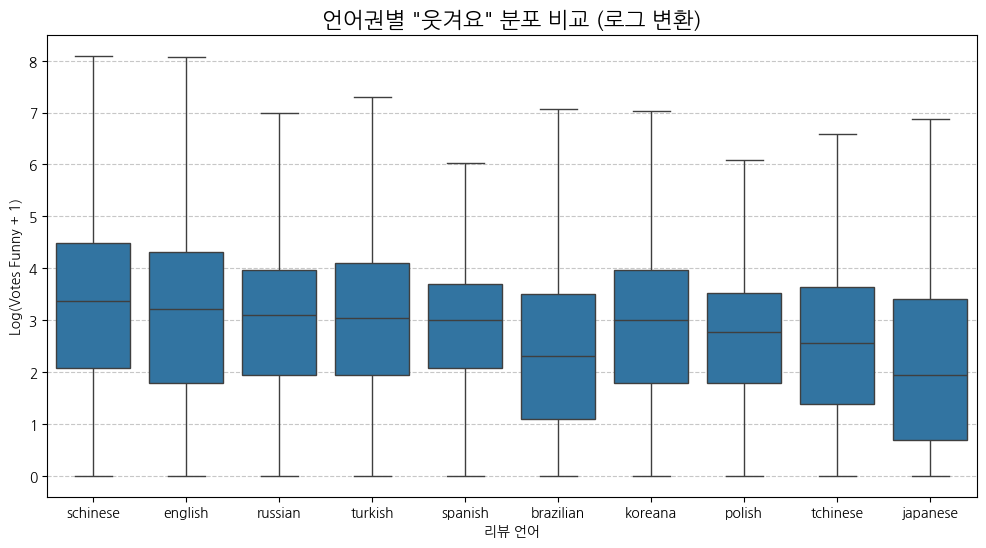

In [ ]:
# ==============================================================================
# 3단계: 언어권별 '리뷰 영향력' 패턴 비교 분석 (변경 불필요)
# ==============================================================================
# (이하 코드는 이전과 동일하게 실행하시면 됩니다)
print("\n--- 3단계: 언어권별 리뷰 영향력 패턴 비교 분석 시작 ---")

df_top_lang['log_votes_up'] = np.log1p(df_top_lang['votes_up'])
df_top_lang['log_votes_funny'] = np.log1p(df_top_lang['votes_funny'])

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_top_lang, x='language', y='log_votes_up', showfliers=False, order=top_languages)
plt.title('언어권별 "도움돼요" 분포 비교 (로그 변환)', fontsize=16)
plt.xlabel('리뷰 언어')
plt.ylabel('Log(Votes Up + 1)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_top_lang, x='language', y='log_votes_funny', showfliers=False, order=top_languages)
plt.title('언어권별 "웃겨요" 분포 비교 (로그 변환)', fontsize=16)
plt.xlabel('리뷰 언어')
plt.ylabel('Log(Votes Funny + 1)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 4.언어별 키워드

In [ ]:
# ==============================================================================
# 4단계 (수정): 강화된 불용어 사전으로 키워드 재분석
# ==============================================================================
print("\n--- 4단계 (수정): 강화된 불용어 사전으로 키워드 재분석 시작 ---")

# 1. 분석에 필요한 함수 및 객체 정의 (이전과 동일)
okt = Okt()
lemmatizer = nltk.stem.WordNetLemmatizer()

def clean_text(text):
    cleaned = re.sub(r'[^A-Za-z가-힣\s]', '', str(text))
    return cleaned.lower()

def english_tokenizer(text):
    tokens = nltk.word_tokenize(text)
    return [lemmatizer.lemmatize(word) for word in tokens if len(word) > 1]

def korean_tokenizer(text):
    tokens = okt.pos(text, stem=True)
    return [word for word, pos in tokens if pos in ['Noun', 'Verb', 'Adjective'] and len(word) > 1]

# 2. 부정 리뷰 필터링 (이전과 동일)
df_negative = df_top_lang[df_top_lang['voted_up'] == 0].copy()

# 3. 모든 언어 그룹에 대해 반복하여 키워드 추출
for lang_code in top_languages:
    print(f"\n--- [원본 언어: {lang_code}] 부정 리뷰 핵심 키워드 Top 15 ---")

    reviews_series = df_negative[df_negative['language'] == lang_code]['translated_en']

    if reviews_series.empty:
        print("-> 분석할 부정 리뷰가 없습니다.")
        continue

    cleaned_reviews = reviews_series.apply(clean_text)

    # ★★★ (수정) 언어별 불용어 사전 대폭 강화 ★★★
    if lang_code == 'koreana':
        tokenizer_func = korean_tokenizer
        # 욕설 및 의미 없는 단어들을 대거 추가합니다.
        stop_words = [
            '게임', '플레이', '유저', '하다', '있다', '되다', '없다', '이다', '같다', '그냥', '정말', '너무', '않다', '좋다',
            '아니다', '보다', '만들다', '진짜', '시간', '이렇다', '스팀', '나오다', '치다',
            '새끼', '시발', '병신', '씨발' # 욕설 필터링
        ]
    else: # 한국어를 제외한 모든 언어 (영어 번역본)
        tokenizer_func = english_tokenizer
        stop_words = list(nltk.corpus.stopwords.words('english'))
        # Lemmatizer가 만들어내는 결과물과, 의미 없는 동사/형용사들을 직접 추가합니다.
        stop_words.extend([
            'game', 'play', 'player', 'get', 'go', 'like', 'one', 'time', 'even', 'make', 'good',
            'wa', 'ha', 'going', 'really', 'want', 'still', 'would' # 문제의 키워드들 제거
        ])

    # 4. TF-IDF 분석 (이하 동일)
    try:
        vectorizer = TfidfVectorizer(
            tokenizer=tokenizer_func,
            stop_words=stop_words,
            max_features=1000,
            min_df=5,
            max_df=0.5
        )
        tfidf_matrix = vectorizer.fit_transform(cleaned_reviews)

        feature_names = vectorizer.get_feature_names_out()
        scores = tfidf_matrix.sum(axis=0).A1
        feature_scores = sorted(zip(feature_names, scores), key=lambda x: x[1], reverse=True)
        top_keywords = [word for word, score in feature_scores[:15]]

        print(top_keywords)

    except ValueError as ve:
         print(f"키워드를 추출할 수 없습니다. ({ve})")
    except Exception as e:
        print(f"분석 중 오류 발생: {e}")


--- 4단계 (수정): 강화된 불용어 사전으로 키워드 재분석 시작 ---

--- [원본 언어: schinese] 부정 리뷰 핵심 키워드 Top 15 ---
['chinese', 'bullying', 'first', 'people', 'playing', 'year', 'buy', 'money', 'bad', 'review', 'new', 'version', 'see', 'back', 'hour']

--- [원본 언어: english] 부정 리뷰 핵심 키워드 Top 15 ---
['buy', 'steam', 'year', 'money', 'price', 'fun', 'better', 'hour', 'bad', 'free', 'version', 'review', 'back', 'people', 'dlc']

--- [원본 언어: russian] 부정 리뷰 핵심 키워드 Top 15 ---
['first', 'playing', 'year', 'buy', 'new', 'developer', 'price', 'money', 'review', 'character', 'hour', 'positive', 'people', 'got', 'back']

--- [원본 언어: turkish] 부정 리뷰 핵심 키워드 Top 15 ---
['turkish', 'playing', 'language', 'fuck', 'money', 'year', 'support', 'hour', 'tl', 'price', 'better', 'give', 'mother', 'friend', 'got']

--- [원본 언어: spanish] 부정 리뷰 핵심 키워드 Top 15 ---
['buy', 'sex', 'year', 'price', 'playing', 'hour', 'review', 'put', 'lot', 'take', 'better', 'see', 'recommend', 'first', 'steam']

--- [원본 언어: brazilian] 부정 리뷰 핵심 키워드 Top 15 ---
[

# 5.인사이트

### 그룹별 특징

- 서구/라틴권 (영어, 스페인어, 브라질어 등): 경제적 합리주의
    - 키워드: price, buy, dlc, money, reais, tl(터키리라)
    - 특징: 비용과 가치 , 현지화(브라질, 터키)
- 동아시아권 : 경험, 커뮤니티
    - 중국: 커뮤니티적 성격
        - 키워드: bullying, chinese
        - 특징: 게임 내에서 다른 유저들과 겪는 사회적 상호작용과 갈등에 대한 불만
    - 한국: 기술적 완성도와 콘텐츠 깊이
        - 키워드: 버그, 서버, 과제, 도전, 중국인
        - 특징: 기술적 문제(버그, 서버), 콘텐츠 깊이(과제, 도전), 중국유저와 갈등(중국인)
    - 일본: 제품의 완성도, 게임 디자인
        - 키워드: version, gameplay, enemy, way
        - 특징: 게임플레이, 적, 버전 문제 등 게임 내부의 만듦새를 지적

### 결론

- 타겟 유저를 명확히 하라
- 지역별 맞춤 전략(Localization)은 필수
    - 현지 통화를 적용한 합리적인 가격 정책이 무엇보다 중요
    - 안정적인 서버, 빠른 버그 수정, 강력한 안티 치트 시스템, 그리고 커뮤니티 관리